In [1]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
pd.options.display.float_format = '{:,.3f}'.format
import argparse
pd.options.mode.chained_assignment = None

import pickle as pkl

from scipy.stats.stats import pearsonr
from scipy.stats.stats import pearsonr

def lemma_maker(x, y):
    #print(lemmatizer.lemmatize(x,y))
    return lemmatizer.lemmatize(x,y)
from functools import reduce

In [2]:
parser = argparse.ArgumentParser(description='Compute features from embeddings')

parser.add_argument('--temporal',  type=int,
                    help='Value to bin the temporal information: 0 (remove temporal information), 1 (no binning), 10 (binning to decades), 20 (binning each 20 years) or 50 (binning each 50 years)')

parser.add_argument('--cutoff', type=int, default=50,
                    help='Cut-off frequency for each compound per time period : none (0), 20, 50 and 100')

parser.add_argument('--contextual', action='store_true',
                    help='Is the model contextual')
parser.add_argument('--inputdir',type=str,
                    help='Provide directory where features are located')
parser.add_argument('--outputdir',type=str,
                    help='Where should the output be stored?')

args = parser.parse_args('--inputdir ../Compounding/coha_compounds/ --contextual --temporal 0 --cutoff 20 --outputdir ../Compounding/coha_compounds/'.split())

In [3]:
print(f'Cutoff: {args.cutoff}')
print(f'Time span:  {args.temporal}')
temp_cutoff_str=str(args.temporal)+'_'+str(args.cutoff)

Cutoff: 20
Time span:  0


In [4]:
if args.contextual:
    comp_df_path=args.inputdir+'/compounds_CompoundAware_'+temp_cutoff_str+'_300.pkl'
    mod_df_path=args.inputdir+'/modifiers_CompoundAware_'+temp_cutoff_str+'_300.pkl'
    head_df_path=args.inputdir+'/heads_CompoundAware_'+temp_cutoff_str+'_300.pkl'
    features_df_path=args.outputdir+'/features_CompoundAware_'+temp_cutoff_str+'_300.pkl'
else:
    comp_df_path=args.inputdir+'/compounds_CompoundAgnostic_'+temp_cutoff_str+'_300.pkl'
    mod_df_path=args.inputdir+'/constituents_CompoundAgnostic_'+temp_cutoff_str+'_300.pkl'
    head_df_path=args.inputdir+'/constituents_CompoundAgnostic_'+temp_cutoff_str+'_300.pkl'
    features_df_path=args.outputdir+'/features_CompoundAgnostic_'+temp_cutoff_str+'_300.pkl'

In [5]:
heads=pd.read_pickle(head_df_path)

if args.temporal!=0:
    heads.index.set_names('time', level=1,inplace=True)
    heads.index.set_names('head',level=0,inplace=True)

else:
    heads.index.set_names('head',inplace=True)

modifiers=pd.read_pickle(mod_df_path)

if args.temporal!=0:
    modifiers.index.set_names('time', level=1,inplace=True)
    modifiers.index.set_names('modifier',level=0,inplace=True)
else:
    modifiers.index.set_names('modifier',inplace=True)


compounds=pd.read_pickle(comp_df_path)

if args.temporal!=0:
    compounds.index.set_names('time', level=2,inplace=True)
compounds.drop(['common'],axis=1,inplace=True)
compounds=compounds+1


In [6]:
if args.temporal!=0:
    all_comps=compounds.reset_index()[['modifier','head','time']]
    mod_prod=compounds.groupby(['modifier','time']).size().to_frame()
    mod_prod.columns=['mod_prod']
    head_prod=compounds.groupby(['head','time']).size().to_frame()
    head_prod.columns=['head_prod']
    prod1=pd.merge(all_comps,mod_prod.reset_index(),how='left',on=['modifier','time'])
    productivity=pd.merge(prod1,head_prod.reset_index(),how='left',on=['head','time'])
    productivity.set_index(['modifier','head','time'],inplace=True)
else:
    all_comps=compounds.reset_index()[['modifier','head']]
    mod_prod=compounds.groupby(['modifier']).size().to_frame()
    mod_prod.columns=['mod_prod']
    head_prod=compounds.groupby(['head']).size().to_frame()
    head_prod.columns=['head_prod']
    prod1=pd.merge(all_comps,mod_prod.reset_index(),how='left',on=['modifier'])
    productivity=pd.merge(prod1,head_prod.reset_index(),how='left',on=['head'])
    productivity.set_index(['modifier','head'],inplace=True)  

In [7]:
productivity

mod_prod  head_prod
modifier        head                               
academy_noun    award_noun             1          2
acceptance_noun speech_noun            1          2
accident_noun   insurance_noun         2         17
                rate_noun              2         19
account_noun    book_noun              1          8
...                                  ...        ...
wrap_noun       paper_noun             1         15
writing_noun    paper_noun             1         15
yacht_noun      club_noun              1         11
yankee_noun     stadium_noun           1          2
zebra_noun      mussel_noun            1          1

[3646 rows x 2 columns]

In [8]:
if args.temporal!=0:
    
    compound_decade_counts=compounds.groupby('time').sum().sum(axis=1).to_frame()
    compound_decade_counts.columns=['N']

    XY=compounds.groupby(['modifier','head','time']).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier','time']).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head','time']).sum().sum(axis=1).to_frame()


else:
    XY=compounds.groupby(['modifier','head']).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier']).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head']).sum().sum(axis=1).to_frame()


    
XY.columns=['a']

X_star.columns=['x_star']
Y_star.columns=['star_y']


if args.temporal!=0:
 
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])
else:
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head'])    

information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']

if args.temporal!=0:
    information_feat=pd.merge(information_feat,compound_decade_counts.reset_index(),on=['time'])



else:
 
    information_feat['N']=compounds.reset_index().drop(['modifier','head'],axis=1).sum().sum()
    

information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']

if args.temporal!=0:

    information_feat.set_index(['modifier','head','time'],inplace=True)
else:
    information_feat.set_index(['modifier','head'],inplace=True)


information_feat.replace(0,0.0001,inplace=True)
information_feat['log_ratio']=2*(information_feat['a']*np.log((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))+\
information_feat['b']*np.log((information_feat['b']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y_bar']))+\
information_feat['c']*np.log((information_feat['c']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y']))+\
information_feat['d']*np.log((information_feat['d']*information_feat['N'])/(information_feat['x_bar_star']*information_feat['star_y_bar'])))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N'])/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat

log_ratio   ppmi  local_mi
modifier         head                                       
academy_noun     award_noun       4,664.368 10.841 3,232.653
achievement_noun award_noun       4,662.513 10.841 3,231.429
acceptance_noun  speech_noun      4,685.153 10.833 3,247.036
keynote_noun     speech_noun      4,687.746 10.833 3,248.749
accident_noun    insurance_noun   2,402.498  6.746 2,017.148
...                                     ...    ...       ...
world_noun       public_noun      2,579.950  6.189 1,856.743
                 revolution_noun  2,590.592  6.189 1,864.383
                 wildlife_noun    2,582.843  6.189 1,858.819
                 wrestling_noun   2,571.998  6.189 1,851.033
zebra_noun       mussel_noun      5,547.434 11.824 3,566.531

[3646 rows x 3 columns]

In [9]:
new_compounds=compounds-1


compound_modifier_sim=new_compounds.multiply(modifiers.reindex(new_compounds.unstack('head').index)).sum(axis=1).to_frame()
compound_modifier_sim.columns=['sim_with_modifier']


compound_head_sim=new_compounds.multiply(heads.reindex(new_compounds.unstack('modifier').index)).sum(axis=1).to_frame()
compound_head_sim.columns=['sim_with_head']


if args.temporal!=0:
    constituent_sim=new_compounds.reset_index()[['modifier','head','time']].merge(modifiers.reset_index(),how='left',on=['modifier','time'])
    constituent_sim.set_index(['modifier','head','time'],inplace=True)
else:
    constituent_sim=new_compounds.reset_index()[['modifier','head']].merge(modifiers.reset_index(),how='left',on=['modifier'])
    constituent_sim.set_index(['modifier','head'],inplace=True)

constituent_sim=constituent_sim.multiply(heads.reindex(constituent_sim.unstack('modifier').index)).sum(axis=1).to_frame()
constituent_sim.columns=['sim_bw_constituents']



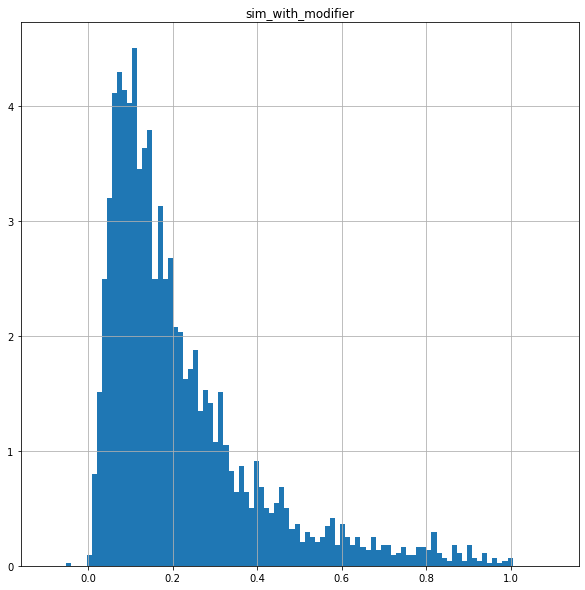

In [10]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

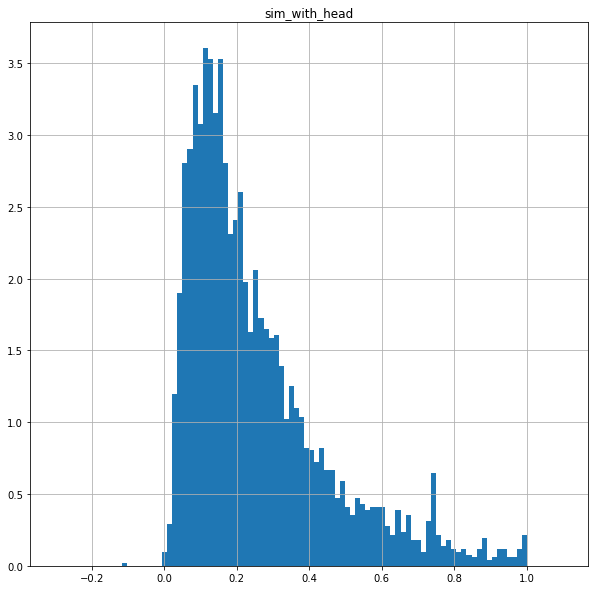

In [11]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

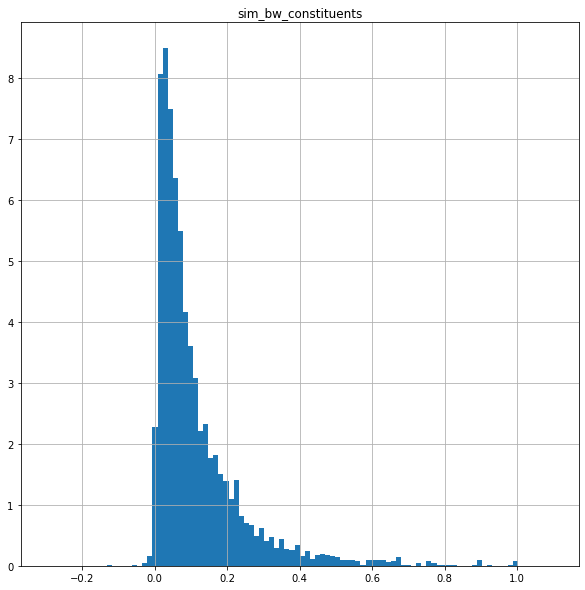

In [12]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [13]:
dfs = [constituent_sim, compound_head_sim, compound_modifier_sim, information_feat,productivity]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)



if args.temporal!=0:
    compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])

    compounds_final.fillna(0,inplace=True)
    compounds_final -= compounds_final.min()
    compounds_final /= compounds_final.max()
    compounds_final_1=compounds_final.columns.get_level_values(0)
    compounds_final_2=compounds_final.columns.get_level_values(1)

    cur_year=0
    new_columns=[]
    for year in compounds_final_2:
        new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
        cur_year+=1
    compounds_final.columns=new_columns


else:
    #compounds_final = reduce(lambda left,right: pd.merge(left,right,on=['modifier','head']), dfs)
    #compounds_final.drop(['head_denom','modifier_denom'],axis=1,inplace=True)
    compounds_final.fillna(0,inplace=True)
    compounds_final -= compounds_final.min()
    compounds_final /= compounds_final.max()

In [14]:
compounds_final

,,sim_bw_constituents,sim_with_head,sim_with_modifier,log_ratio,ppmi,local_mi,mod_prod,head_prod
modifier,head,,,,,,,,
dressing_noun,gown_noun,0.118,0.376,0.091,0.633,0.764,0.760,0.027,0.022
escape_noun,route_noun,0.220,0.252,0.329,0.842,0.908,0.903,0.000,0.022
steel_noun,industry_noun,0.172,0.219,0.289,0.177,0.267,0.266,0.149,0.457
parking_noun,space_noun,0.140,0.229,0.116,0.416,0.544,0.541,0.041,0.152
alpha_noun,delta_noun,0.599,0.730,0.689,0.843,0.908,0.905,0.014,0.000
...,...,...,...,...,...,...,...,...,...
vigilance_noun,committee_noun,0.119,0.202,0.080,0.542,0.588,0.584,0.000,0.478
rock_noun,salt_noun,0.117,0.143,0.128,0.453,0.582,0.577,0.095,0.043
peasant_noun,girl_noun,0.181,0.472,0.343,0.427,0.553,0.549,0.027,0.196
